# Research Request - Service Data for SJCOG #1476
https://github.com/cal-itp/data-analyses/issues/1476

explore trying to answer these questions from the issue:

- share some information from NTD on what % of services are provided by SJRTD.
- see if NTD can help us tell what each operators need is for that region.

- see if NTD shows you the operations just in a particular UZA.
    - yeah, can sort by UZA, need to find the specific table. 
- Are you able to see specifically within the Tracy boundaries which percentage of service is provided by City of Tracy vs SJRTD?
    - the STIC dataset can, see above
- Can NTD tell you the funding for each operator by source?
    - probably, there are some tables that sort by fed/state amount
- Can you tell what level of 5307, 5311, TDA, LCTOP etc they [operators?] get from there?

However, these question revolve around knowing the proportion of service that happens between area, not just the agencies main area. Example, the UZA for SJRTD is "Stockton, CA". But SJRTD runs service that goes outside of Stockton (some bus routes go to Tracy, Ripon, Lodi)

In [1]:
import altair as alt
import pandas as pd
from calitp_data_analysis.tables import tbls
from siuba import _, collect, count, filter, group_by, select, show_query, summarize

# from update_vars import GCS_FILE_PATH, NTD_MODES, NTD_TOS

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## 1. See if NTD can help us tell what each operators need is for that region.
- found [FTA apportionment site](https://www.transit.dot.gov/funding/apportionments/current-apportionments). Might just be all apportionments, not just STIC?
- [Formula Apportionment Data Page](https://www.transit.dot.gov/funding/apportionments/formula-apportionments-data). Includes STIC, 5311 and other tribal funds
    - subpage for [National Transit Database Data Used for the Small Transit Intensive Cities (STIC) Apportionments](https://www.transit.dot.gov/funding/apportionments/national-transit-database-data-used-small-transit-intensive-cities-stic)
- What about [Table 6. FY 2025 Section 5307 Small Transit Intensive Cities Apportionments (Partial Year) data](https://www.transit.dot.gov/funding/apportionments/table-6-fy-2025-section-5307-small-transit-intensive-cities-apportionments)

## 2. see if NTD shows you the operations just in a particular UZA.
- like the UPT for each UZA?
- The `National Transit Database Data Used for the Small Transit Intensive Cities (STIC) Apportionments` data shows how much UPT (other metrics) were used for each UZA.
- see below, just Tracy UZA
<br>
<br>

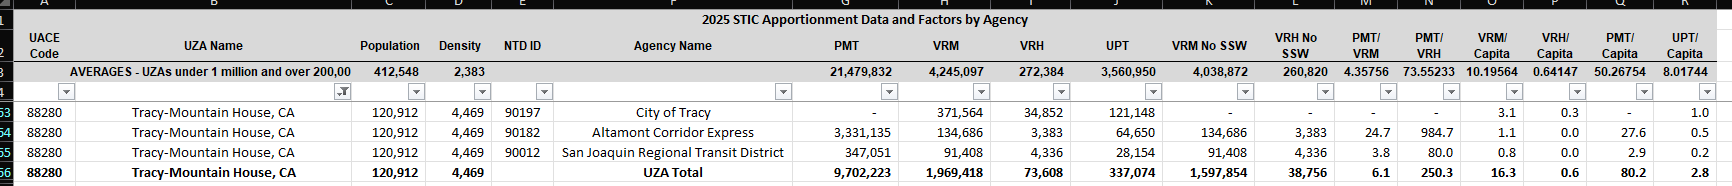



## 3. Are you able to see specifically within the Tracy boundaries which percentage of service is provided by City of Tracy vs SJRTD?
- via `National Transit Database Data Used for the Small Transit Intensive Cities (STIC) Apportionments`, sorted by agency
<br>
<br>

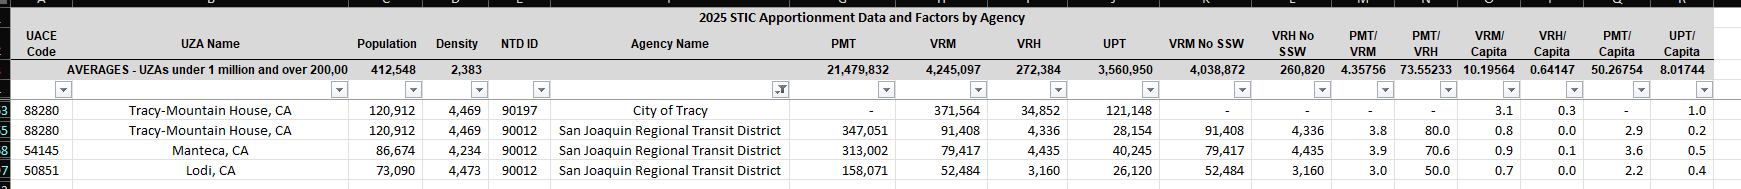


## 4. Can NTD tell you the funding for each operator by source?
 - maybe `mart_ntd_annual_reporting.fct_funding_sources_federal` & `mart_ntd_annual_reporting.fct_funding_sources_state`?

## 5. Can you tell what level of 5307, 5311, TDA, LCTOP etc they [operators?] get from there?
- https://data.transportation.gov/Public-Transit/2022-2023-NTD-Annual-Data-Funding-Sources-Federal-/qpjk-b3zw/about_data has column for `FTA Urbanized Area Formula Prograp (5307) and Bus & Bus Facilities (5339)` & `FTA Rural Progam (5311)` for federal stuff. 
- is LCTOP and TDA is state?

In [2]:
# Cities in San Joaquin County
sj_cities = [
    "Stockton",
    "Escalon",
    "Tracy",
    "Lathrop",
    "Lodi",
    "Manteca",
    "Mountain House",
    "Ripon",
    "Acampo",
    "French Camp",
    "Garden Arcres",
]

In [3]:
ca = (
    tbls.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrh()
    >> filter(
        _.state == "CA",
        # _.city == "Stockton"
        # _.report_year == 2023
    )
    >> group_by(
        _.agency_name, 
        _.ntd_id, 
        _.reporter_type, 
        _.primary_uza_name, 
        _.last_report_year, 
        _.city
    )
    >> summarize(total_vrh=_.vrh.sum())
    >> collect()
)  # .fillna(0)

ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   agency_name       269 non-null    object 
 1   ntd_id            254 non-null    object 
 2   reporter_type     269 non-null    object 
 3   primary_uza_name  269 non-null    object 
 4   last_report_year  269 non-null    int64  
 5   city              255 non-null    object 
 6   total_vrh         268 non-null    float64
dtypes: float64(1), int64(1), object(5)
memory usage: 14.8+ KB


In [4]:
ca["city"].isna().value_counts()

False    255
True      14
Name: city, dtype: int64

In [5]:
ca.fillna("none")["city"].isna().value_counts()

False    269
Name: city, dtype: int64

In [16]:
# How many agencies have Tracy as their primary uza?
for i in sj_cities:
        if len(ca[ca["primary_uza_name"].str.contains(i)]) >0:
            display(
            f"Agencies with {i} as UZA",
            ca[ca["primary_uza_name"].str.contains(i)],
            f"Agencies with {i} as City",
            ca[ca["city"].notna() & ca["city"].str.contains(i)],
        )

'Agencies with Stockton as UZA'

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_vrh
7,Altamont Corridor Express (ACE),90182,Full Reporter,"Stockton, CA",2023,Stockton,529179.0
131,San Joaquin Regional Transit District (RTD),90012,Full Reporter,"Stockton, CA",2023,Stockton,7249405.0
254,San Joaquin Council (SJCOG),99422,Full Reporter,"Stockton, CA",2023,Stockton,650385.0


'Agencies with Stockton as City'

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_vrh
7,Altamont Corridor Express (ACE),90182,Full Reporter,"Stockton, CA",2023,Stockton,529179.0
131,San Joaquin Regional Transit District (RTD),90012,Full Reporter,"Stockton, CA",2023,Stockton,7249405.0
254,San Joaquin Council (SJCOG),99422,Full Reporter,"Stockton, CA",2023,Stockton,650385.0


'Agencies with Tracy as UZA'

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_vrh
62,City of Tracy - Transit Division,90197,Reduced Reporter,"Tracy--Mountain House, CA",2023,Tracy,370073.0


'Agencies with Tracy as City'

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_vrh
62,City of Tracy - Transit Division,90197,Reduced Reporter,"Tracy--Mountain House, CA",2023,Tracy,370073.0


'Agencies with Lodi as UZA'

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_vrh
186,City of Lodi - Public Works Department,90175,Reduced Reporter,"Lodi, CA",2023,Lodi,1032308.0


'Agencies with Lodi as City'

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_vrh
186,City of Lodi - Public Works Department,90175,Reduced Reporter,"Lodi, CA",2023,Lodi,1032308.0


'Agencies with Manteca as UZA'

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_vrh
190,City of Manteca - Transit Division,90217,Reduced Reporter,"Manteca, CA",2023,Manteca,179908.0


'Agencies with Manteca as City'

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_vrh
190,City of Manteca - Transit Division,90217,Reduced Reporter,"Manteca, CA",2023,Manteca,179908.0


'Agencies with Mountain House as UZA'

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_vrh
62,City of Tracy - Transit Division,90197,Reduced Reporter,"Tracy--Mountain House, CA",2023,Tracy,370073.0


'Agencies with Mountain House as City'

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_vrh


In [7]:
# how many cities does SJRTD serve?
ca[ca["ntd_id"]=="90012"]

# just stockton?

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_vrh
131,San Joaquin Regional Transit District (RTD),90012,Full Reporter,"Stockton, CA",2023,Stockton,7249405.0


In [12]:
opex = (
    tbls.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_opexp_total()
    >> filter(
        _.state == "CA",
        _.city.isin(sj_cities)
        # _.report_year == 2023
    )
    >> group_by(
        _.agency_name, 
        _.ntd_id, 
        _.reporter_type, 
        _.primary_uza_name, 
        _.last_report_year, 
        _.city
    )
    >> summarize(total_opex=_.opexp_total.sum())
    >> collect()
)  # .fillna(0)

opex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   agency_name       7 non-null      object
 1   ntd_id            7 non-null      object
 2   reporter_type     7 non-null      object
 3   primary_uza_name  7 non-null      object
 4   last_report_year  7 non-null      int64 
 5   city              7 non-null      object
 6   total_opex        7 non-null      int64 
dtypes: int64(2), object(5)
memory usage: 524.0+ bytes


In [13]:
opex

,agency_name,ntd_id,reporter_type,primary_uza_name,last_report_year,city,total_opex
0,Altamont Corridor Express (ACE),90182,Full Reporter,"Stockton, CA",2023,Stockton,383587773
1,City of Tracy - Transit Division,90197,Reduced Reporter,"Tracy--Mountain House, CA",2023,Tracy,39452983
2,San Joaquin Regional Transit District (RTD),90012,Full Reporter,"Stockton, CA",2023,Stockton,812747600
3,City of Escalon - Transit Services,91078,Reduced Reporter,"Modesto, CA",2023,Escalon,1425631
4,City of Lodi - Public Works Department,90175,Reduced Reporter,"Lodi, CA",2023,Lodi,76635571
5,City of Manteca - Transit Division,90217,Reduced Reporter,"Manteca, CA",2023,Manteca,18327728
6,San Joaquin Council (SJCOG),99422,Full Reporter,"Stockton, CA",2023,Stockton,16410211


In [8]:
# what are the routes for SJRTD?
# what GTFS table is there 
# mart_transit_database.bridge_organizations_x_services_managed



dim_agency_info has service area, could be a point of comparison

>SELECT DISTINCT
>  agency_name, city, primary_uza_name, zip_code, service_area_pop, service_area_sq_miles, population, sq_miles, density
>FROM
>  `cal-itp-data-infra.mart_ntd_annual_reporting.dim_agency_information`
>WHERE
>  state = "CA"
>  
>LIMIT
>  1000